### Importing Libraries and Preprocessing

In [44]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import *
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,classification_report,roc_curve,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from numpy.random import seed 
import warnings
warnings.filterwarnings("ignore")
#nltk.download('all')

In [2]:
df = pd.read_excel('bepec_p.xlsx',engine='openpyxl')
df.columns=['Description','Target']
df.head()

,Description,Target
0,"Php, python, js, c",Good
1,Python and R,Good
2,No,Novice
3,Not yet,Novice
4,"Yes I had experience in C, C++, and python but...",Novice


In [3]:
df.describe(include='O')

,Description,Target
count,390,391
unique,223,4
top,No,Novice
freq,61,169


In [4]:
df.isnull().sum()

Description    7
Target         6
dtype: int64

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

Description    0
Target         0
dtype: int64

In [6]:
df.Target.value_counts()

Novice     168
Average    147
Good        74
Na           1
Name: Target, dtype: int64

In [7]:
index = df[df['Target']=='Na'].index
df.drop(index,inplace=True)

In [8]:
df.Target.value_counts()

Novice     168
Average    147
Good        74
Name: Target, dtype: int64

### NLP Techniques

In [9]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [10]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [11]:
def preprocessing_step(sentence):
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A) #Removing Numbers
    sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence) ##Removing punctuations
    sentence = sentence.lower()
    stopwords_set = set(stopwords.words('english'))
    stopwords_filtered = [word for word in stopwords_set if word not in ["not","no","nor","don't","aren't","couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't","isn't","mightn't","mustn't",  "needn't","shouldn't","wasn't","weren't","won't","wouldn't"]]
    preprocessed = [word for word in sentence.split(',') if not word in stopwords_filtered]
    #preprocessed = ''.join(preprocessed)
    return preprocessed


In [12]:
processed_list=[]
lemmatizer = WordNetLemmatizer()
for each_description in df['Description']:
    processed=preprocessing_step(each_description)
    processed_list.append(processed)

In [13]:
df['Preprocessed_Description'] = processed_list

In [14]:
final_df=pd.DataFrame()
final_df['Description']=df['Preprocessed_Description'].astype(str)
final_df['Target'] = df['Target']

#### Word Cloud to visualize the pattern behind the Good,Average,Novice Programmers

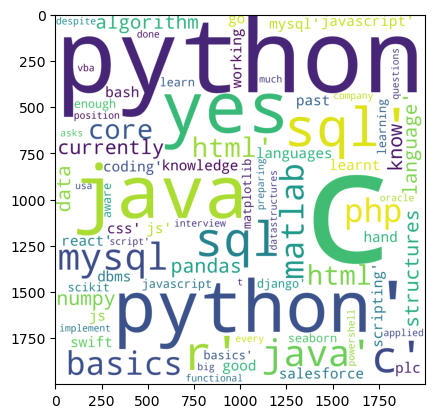

In [15]:
from wordcloud import WordCloud
wc=WordCloud(width=2000,height=2000,background_color='white')
wc = wc.generate(final_df[final_df['Target']=='Good']['Description'].str.cat(sep=" "))
plt.imshow(wc)

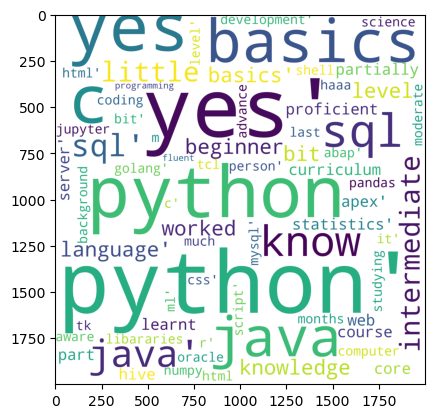

In [16]:
from wordcloud import WordCloud
wc=WordCloud(width=2000,height=2000,background_color='white')
wc = wc.generate(final_df[final_df['Target']=='Average']['Description'].str.cat(sep=" "))
plt.imshow(wc)

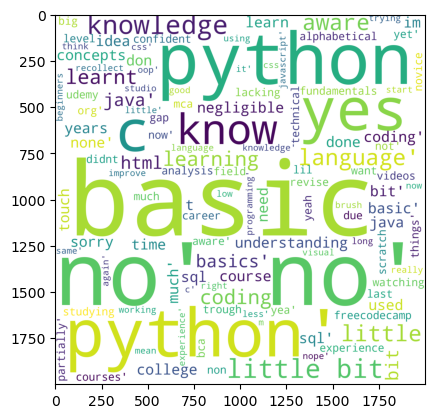

In [17]:
from wordcloud import WordCloud
wc=WordCloud(width=2000,height=2000,background_color='white')
wc = wc.generate(final_df[final_df['Target']=='Novice']['Description'].str.cat(sep=" "))
plt.imshow(wc)

In [18]:
def get_rank(x):
    if x=='Novice':
        return 0
    elif x=='Average':
        return 1
    elif x=='Good':
        return 2
    else:
        return None
    

y=final_df['Target'].apply(lambda x: get_rank(x))

#### Model Building

In [19]:
corpus=[]
for each_description in final_df['Description']:
    processed=''.join(each_description)
    processed=processed[2:-2]
    corpus.append(processed)

In [20]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [21]:
onehot_repr=[one_hot(words,50)for words in corpus] 

In [22]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[ 0  0  0 ...  2 48  1]
 [ 0  0  0 ...  2 42 10]
 [ 0  0  0 ...  0  0 34]
 ...
 [ 0  0  0 ...  0  0 39]
 [ 0  0  0 ...  0  0 39]
 [ 0  0  0 ...  0  0 34]]


In [23]:
len(embedded_docs),y.shape

(389, (389,))

##### Model Architecture

In [24]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [25]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [26]:
X_final.shape,y_final.shape

((389, 20), (389,))

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [28]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [47]:
embedding_vector_features=50
model=Sequential()
model.add(Embedding(50,embedding_vector_features,input_length=sent_length))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(32,activation='LeakyReLU'))

model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 50)            2500      
                                                                 
 lstm_4 (LSTM)               (None, 20, 256)           314368    
                                                                 
 lstm_5 (LSTM)               (None, 20, 128)           197120    
                                                                 
 lstm_6 (LSTM)               (None, 20, 128)           131584    
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                

In [48]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),initial_epoch=0,epochs=100,use_multiprocessing=True,class_weight={0:0.3,1:0.2,2:0.5})

Epoch 1/100
9/9 [==============================] - 6s 183ms/step - loss: 0.3291 - accuracy: 0.3731 - f1: 0.0000e+00 - val_loss: 1.0879 - val_accuracy: 0.5116 - val_f1: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 0s 26ms/step - loss: 0.3270 - accuracy: 0.3923 - f1: 0.0000e+00 - val_loss: 1.0870 - val_accuracy: 0.5116 - val_f1: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 0s 27ms/step - loss: 0.3272 - accuracy: 0.3923 - f1: 0.0000e+00 - val_loss: 1.0842 - val_accuracy: 0.5116 - val_f1: 0.0000e+00
Epoch 4/100
9/9 [==============================] - 0s 26ms/step - loss: 0.3270 - accuracy: 0.3923 - f1: 0.0000e+00 - val_loss: 1.0852 - val_accuracy: 0.5116 - val_f1: 0.0000e+00
Epoch 5/100
9/9 [==============================] - 0s 27ms/step - loss: 0.3261 - accuracy: 0.3923 - f1: 0.0000e+00 - val_loss: 1.0913 - val_accuracy: 0.5116 - val_f1: 0.0000e+00
Epoch 6/100
9/9 [==============================] - 0s 28ms/step - loss: 0.3282 - accuracy: 0.3923 - f1: 0.000

9/9 [==============================] - 0s 27ms/step - loss: 0.0677 - accuracy: 0.9231 - f1: 0.8835 - val_loss: 0.5874 - val_accuracy: 0.8450 - val_f1: 0.8750
Epoch 49/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0679 - accuracy: 0.9231 - f1: 0.9258 - val_loss: 0.6258 - val_accuracy: 0.8295 - val_f1: 0.8648
Epoch 50/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0672 - accuracy: 0.9115 - f1: 0.9229 - val_loss: 0.5719 - val_accuracy: 0.8450 - val_f1: 0.8750
Epoch 51/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0610 - accuracy: 0.9231 - f1: 0.9300 - val_loss: 0.6150 - val_accuracy: 0.8372 - val_f1: 0.8687
Epoch 52/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0596 - accuracy: 0.9231 - f1: 0.9058 - val_loss: 0.6600 - val_accuracy: 0.8450 - val_f1: 0.8750
Epoch 53/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0691 - accuracy: 0.9115 - f1: 0.9061 - val_loss: 0.6544 - val_accuracy: 0.8450 - va

Epoch 96/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0377 - accuracy: 0.9577 - f1: 0.9618 - val_loss: 1.0195 - val_accuracy: 0.8295 - val_f1: 0.8625
Epoch 97/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0290 - accuracy: 0.9692 - f1: 0.9722 - val_loss: 0.9595 - val_accuracy: 0.8295 - val_f1: 0.8652
Epoch 98/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0269 - accuracy: 0.9731 - f1: 0.9757 - val_loss: 0.9928 - val_accuracy: 0.8295 - val_f1: 0.8652
Epoch 99/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0270 - accuracy: 0.9731 - f1: 0.9757 - val_loss: 1.0105 - val_accuracy: 0.8372 - val_f1: 0.8687
Epoch 100/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0261 - accuracy: 0.9731 - f1: 0.9757 - val_loss: 1.0226 - val_accuracy: 0.8295 - val_f1: 0.8625


In [49]:
predicted = model.predict(X_test)

5/5 [==============================] - 1s 24ms/step


In [50]:
predicted_labels=[np.argmax(i) for i in predicted]
expected_labels=[np.argmax(i) for i in y_test]

In [51]:
result=pd.DataFrame()
result['Expected']=expected_labels
result['Predicted']=predicted_labels
pd.set_option('Display.max_rows',None)
result

,Expected,Predicted
0,2,0
1,0,0
2,0,0
3,0,0
4,2,2
5,1,1
6,1,1
7,2,2
8,1,0
9,1,1


### Confusion Matrix for evaluation

In [34]:
def custom_confusion_matrix(df: pd.DataFrame, col1: str, col2: str):

    return (
            df
            .groupby([col1, col2])
            .size()
            .unstack(fill_value=0)
            )

In [54]:
cm=custom_confusion_matrix(result, 'Expected','Predicted')

Text(95.72222222222221, 0.5, 'Expected')

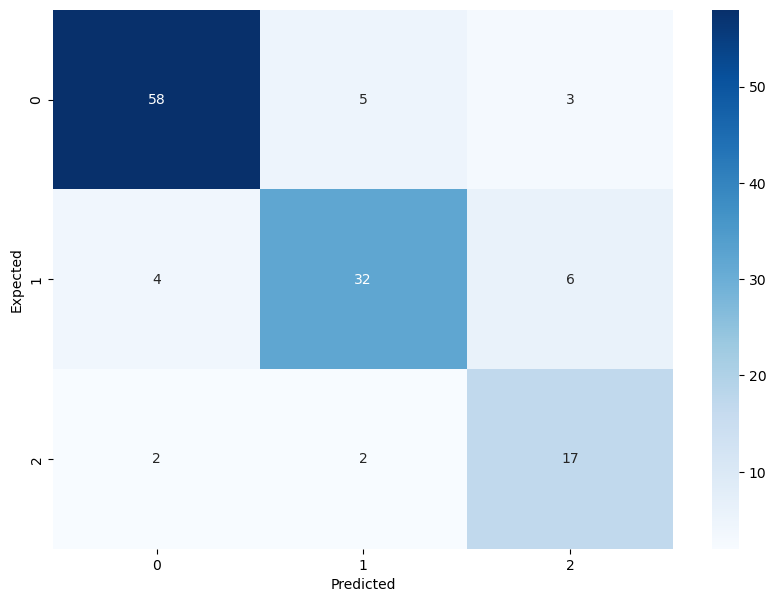

In [58]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Expected')

In [52]:
model.save('model_lstm.h5')

#### Testing using random data

In [53]:
from tensorflow.keras.models import load_model
corpus = ['python,php,c']
model2 = load_model('model_lstm.h5',custom_objects={'f1':f1})
sent_length=20
onehot_repr=[one_hot(words,50)for words in corpus] 
embedded_docs_test= pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
prediction=model2.predict(embedded_docs_test)
predicted_labels=[np.argmax(i) for i in prediction]
predicted_labels="".join(str(x) for x in predicted_labels)
predicted_labels=int(predicted_labels)
if predicted_labels==0:
    print()
    print('''He/She is newbie to Programming''')
elif predicted_labels==1:
     print('''He/She is average in Programming''')       
else:
    print('''He/She is good in Programming''')

1/1 [==============================] - 1s 1s/step
He/She is good in Programming
